# Notebook 2 : UK data analysis + LDA + Filtering the top 20 newspapers

In [2]:
import pandas as pd
import numpy as np
import glob
import requests
import json
import tldextract
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import gensim
from gensim import corpora, models
nltk.download('stopwords')
SOME_FIXED_SEED = 42
np.random.seed(SOME_FIXED_SEED)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/meftahzi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Filter out the non relevant tags and subdomains of the top 20 domains + Notebook 1 cleaning :

* the table with the top 20 domains and their relevant tags can be found under "domain filtering.pdf"

In [3]:
relevant= ["bbc.co.uk/news/",
"Ablink.editorial.theguardian.com",
"theguardian.com/news/",
"theguardian.com/world/",
"theguardian.com/commentisfree/",
"theguardian.com/us-news/",
"theguardian.com/uk-news/",
"theguardian.com/politics/",
"theguardian.com/education/",
"theguardian.com/society/",
"theguardian.com/science/",
"theguardian.com/business/",
"theguardian.com/money/",
"theguardian.com/sport/",
"theguardian.com/australia-news/",
"theguardian.com/travel/",
"theguardian.com/technology/",
"theguardian.com/commentisfree/",
"dailymail.co.uk/news/",
"dailymail.co.uk/columnists/",
"dailymail.co.uk/debate/",
"dailymail.co.uk/femail/",
"dailymail.co.uk/health/",
"dailymail.co.uk/money/",
"dailymail.co.uk/sport/",
"dailymail.co.uk/travel/",
"dailymail.co.uk/tvshowbiz/",
"news.sky.com/story/",
"thesun.co.uk/fabulous/",
"thesun.co.uk/money/",
"thesun.co.uk/news/",
"thesun.co.uk/sport/",
"thesun.co.uk/travel/",
"thesun.co.uk/tech/",
"www.telegraph.co.uk/politics/",
"www.telegraph.co.uk/news/",
"express.co.uk",
"metro.co.uk",
"itv.com/news",
"independent.co.uk/news",
"thetimes.co.uk/article",
"www.channel4.com/news",
"inews.co.uk/news",
"thetelegraphandargus.co.uk/news",
"nytimes.com/20",
"standard.co.uk/news",
"kentonline.co.uk",
"ft.com/content",
"eveningtimes.co.uk/news",
"eveningtimes.co.uk/content"]

In [4]:
news = pd.DataFrame()
DATA_FILES = ['uk/newspaper.json']
for filepath in DATA_FILES:
    current_news = pd.read_json(filepath, lines=True)
    current_news['country'] = filepath[:2]
    news = news.append(current_news)
    

news.reset_index(inplace=True, drop=True)

In [15]:
media_portals= news[(news['meta_lang'] == 'en') | (news['meta_lang'].isnull())] #select only articles with 'en' meta_lang or with empty

In [16]:
media_portals=media_portals[media_portals.url.str.contains('|'.join(relevant))]

In [17]:
media_portals=media_portals[media_portals["url"].str.contains("express.co.uk/showbiz|discountcode.metro.co.uk|Link.news.metro.co.uk|www.metro.co.uk|api.metro.co.uk")==False]
media_portals

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country
1,LIVE: NZ terror attacks - Gun law reforms with...,Image:\n\nA man lays flowers for victims of th...,None,[https://e3.365dm.com/19/03/768x432/skynews-ne...,None,en,[],GER_2019-03-15_71_web_page.html,news.sky.com/story/live-significant-number-kil...,NaN,uk
7,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1075_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk
8,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1076_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk
20,Christchurch shootings: 49 dead in New Zealand...,Media playback is unsupported on your device M...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-03-15_1563_web_page.html,www.bbc.co.uk/news/world-asia-47578798,NaN,uk
21,David Steel suspended by Liberal Democrats ove...,Image copyright Getty Images Image caption Lor...,None,[https://ichef.bbci.co.uk/news/320/cpsprodpb/1...,None,en,[],GER_2019-03-15_1564_web_page.html,www.bbc.co.uk/news/uk-scotland-scotland-politi...,NaN,uk
...,...,...,...,...,...,...,...,...,...,...,...
120568,Conservative leadership field slims to six as ...,Conservative leadership field slims to six as ...,"[Greg Heffer, Political Reporter]",[https://e3.365dm.com/19/06/768x432/skynews-ma...,None,en,[],GER_2019-06-15_1622_mobile_.html,news.sky.com/story/conservative-leadership-fie...,NaN,uk
120569,'Glazed ring' donut jokes gets city boss from ...,Sign me up for news alerts\n\nA city boss has ...,None,"[http://fox13now.com/1x1.gif, http://fox13now....",None,en,"[Business News, Quirky, Kent, People & Employm...",GER_2019-06-15_1623_mobile_.html,www.kentonline.co.uk/kent/news/boss-suspended-...,NaN,uk
120576,Former Arsenal footballer Ian Wright taught hi...,Ian Wright has opened up about warning his chi...,[Rishma Dosani],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,[https://www.youtube.com/embed/E7Cs9MJnwuI?ver...,en,[],GER_2019-06-15_2463_mobile_.html,metro.co.uk/2019/06/15/ian-wright-taught-child...,NaN,uk
120579,Amazon Echo price drops AGAIN as owners get a ...,Amazon Echo now gets voice calling from Vodafo...,[David Snelling],[https://cdn.images.express.co.uk/img/covers/7...,None,en,[],GER_2019-06-15_4600_mobile_.html,www.express.co.uk/life-style/science-technolog...,NaN,uk


## check how many articles we have with all the tags from the top 20:

In [18]:
alltwenty= ["bbc.co.uk",
"theguardian.com",
"dailymail.co.uk",
"sky.com",
"thesun.co.uk",
"www.telegraph.co.uk",
"express.co.uk",
"metro.co.uk",
"itv.com",
"independent.co.uk",
"thetimes.co.uk",
"www.channel4.com",
"inews.co.uk",
"thetelegraphandargus.co.uk",
"nytimes.com",
"standard.co.uk",
"kentonline.co.uk",
"ft.com",
"eveningtimes.co.uk",
"buzzfeed.com"]

In [19]:
len(news[news.url.str.contains('|'.join(alltwenty))])

86346

## Checking the number of occurences of articles based on title and text seperately :

In [20]:
news[news.text.str.contains("That's why our new email newsletter will deliver a mobile-friendly snapshot of inews.co.uk", case=False, na=False)]

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country
1146,Mendip House care home has been fined a deriso...,The i's Essential Daily Briefing\n\nWe know th...,[Ian Birrell],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-03-15_74657_web_page.html,inews.co.uk/opinion/columnists/mendip-house-au...,NaN,uk
1172,The lesbian ‘blood sisters’ who cared for gay ...,The i's Essential Daily Briefing\n\nWe know th...,[Dr Kate Lister],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-03-15_78007_web_page.html,inews.co.uk/opinion/comment/the-lesbian-blood-...,NaN,uk
1173,‘There were days we couldn’t buy food’: why as...,The i's Essential Daily Briefing\n\nWe know th...,[Nahla Ellozi],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-03-15_78008_web_page.html,inews.co.uk/opinion/why-asylum-seekers-should-...,NaN,uk
2595,"When is Mother’s Day 2019, what are origins of...",The i's Essential Daily Briefing\n\nWe know th...,[David Hughes],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-03-16_8058_mobile_.html,inews.co.uk/light-relief/offbeat/mothers-day-2...,NaN,uk
2596,"When is Mother’s Day 2019, what are origins of...",The i's Essential Daily Briefing\n\nWe know th...,[David Hughes],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-03-16_8059_mobile_.html,inews.co.uk/light-relief/offbeat/mothers-day-2...,NaN,uk
...,...,...,...,...,...,...,...,...,...,...,...
93204,Michael Gove to challenge Boris Johnson for To...,The i's Essential Daily Briefing\n\nWe know th...,[Nick Duffy],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-05-26_23048_web_page.html,inews.co.uk/news/politics/michael-gove-to-chal...,NaN,uk
93502,Can UK enter Eurovision after Brexit? How leav...,The i's Essential Daily Briefing\n\nWe know th...,[Charlie Duffield],[https://edition.pagesuite-professional.co.uk/...,None,en,[],GER_2019-05-26_43942_web_page.html,inews.co.uk/news/brexit/eurovision-2019-brexit...,NaN,uk
93503,Matt Hancock warns the next Prime Minister not...,The i's Essential Daily Briefing\n\nWe know th...,[Georgina Littlejohn],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-05-26_43943_web_page.html,inews.co.uk/news/matt-hancock-warns-next-prime...,NaN,uk
93600,Nigel Farage ‘will take over’ as leader of the...,The i's Essential Daily Briefing\n\nWe know th...,[Serina Sandhu],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-05-26_48204_web_page.html,inews.co.uk/news/nigel-farage-leader-brexit-pa...,NaN,uk


In [21]:
pd.DataFrame(media_portals.text.value_counts())

text
The i's Essential Daily Briefing\n\nWe know tha...   349
What term do you want to search? Search with go...   278
Make informed decisions with the FT\n\nKeep abr...   171
Have Your Say                                         56
i Search\n\nCheck the URL for errors or try our...    52
...                                                  ...
It was a bright but chilly Thursday morning whe...     1
Image copyright Edrington\n\nA whisky advert fe...     1
ES News email The latest headlines in your inbo...     1
Number of unbanked people has fallen to 1.2 mil...     1
Birmingham's cheapest property has hit the mark...     1

[30193 rows x 1 columns]

In [22]:
media_portals['txt_counts'] = media_portals['text'].map(media_portals['text'].value_counts())
media_portals['title_counts'] = media_portals['title'].map(media_portals['title'].value_counts())

In [23]:
criteria=50
s=media_portals[media_portals['txt_counts']<=criteria]
print("Number of articles with text occurence less than "+ str(criteria) +" :" + str(len(s)))
s=media_portals[media_portals['title_counts']<=criteria]
print("Number of articles with title occurence less than "+ str(criteria) +" :" + str(len(s)))
s=media_portals[(media_portals['txt_counts']<=criteria) & (media_portals['title_counts']<=criteria)]
print("Number of articles with title and text occurence combined less than "+ str(criteria) +" :" + str(len(s)))
s.reset_index(inplace=True, drop=True)

Number of articles with text occurence less than 50 :36541
Number of articles with title occurence less than 50 :37373
Number of articles with title and text occurence combined less than 50 :36265


## Data preprocessing :

In [49]:
a=s
a.drop_duplicates(subset='text', keep='first')
a.drop_duplicates(subset='title', keep='first')
a= a.sample(n=5000)
a

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,txt_counts,title_counts
14002,Housing developers get stern warning as two bi...,Get the biggest Daily stories by email Subscri...,"[Angus Young, Image, Hull Daily Mail, Peter Ha...",[http://fox13now.com/@trinitymirrordigital/mar...,None,None,"[East Riding of Yorkshire Council, Cottingham]",GER_2019-04-21_60844_web_page.html,www.hulldailymail.co.uk/news/hull-east-yorkshi...,NaN,uk,1.0,1.0
9790,The team that feels like a second family,The women of Sutton & Epsom's Ladies RFC are o...,None,[https://ichef.bbci.co.uk/news/320/cpsprodpb/A...,None,en,[],GER_2019-04-09_79634_web_page.html,www.bbc.co.uk/news/in-pictures-47831386,NaN,uk,1.0,1.0
26217,Piers Morgan admits Mel B's Geri Halliwell sex...,Piers Morgan got a Spice Girls scoop during fi...,[Joanna Crawley For Mailonline],[https://i.dailymail.co.uk/1s/2019/09/13/08/18...,None,en,"[dailymail, tvshowbiz, mel-b]",GER_2019-05-22_72212_web_page.html,www.dailymail.co.uk/tvshowbiz/article-6852087/...,NaN,uk,1.0,1.0
18583,Billy McNeill funeral: Applause across Glasgow...,RAPTUROUS applause was heard across Glasgow on...,None,[http://fox13now.com/resources/static/nile/img...,None,en,[],GER_2019-05-03_51507_web_page.html,eveningtimes.co.uk/news/17617149.billy-mcneill...,NaN,uk,27.0,27.0
17757,National Trust axes Belton Horse Trials,Image copyright National Trust Image caption T...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-05-01_80190_web_page.html,www.bbc.co.uk/news/uk-england-lincolnshire-481...,NaN,uk,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21903,Lowestoft sea wall fall cyclist rescued by friend,Image copyright Maritime and Coastguard Agency...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-05-12_11189_web_page.html,bbc.co.uk/news/uk-england-suffolk-48243015,NaN,uk,1.0,2.0
13900,Sri Lanka bombings: Intelligence blunder ahead...,Key intelligence on a possible terrorist attac...,"[Nicola Smith, Susitha Fernando, Qadijah Irsha...",[http://fox13now.com/content/dam/news/2019/08/...,None,en,"[Sri Lanka, News, World News]",GER_2019-04-21_28710_web_page.html,www.telegraph.co.uk/news/2019/04/21/sri-lanka-...,NaN,uk,2.0,2.0
23308,Father of girl photo-bombed by 'ghost-like sam...,'I'm about as skeptical as they come when it c...,[Daniel Piotrowski For Daily Mail Australia],[https://i.dailymail.co.uk/1s/2019/09/06/14/18...,None,en,"[dailymail, news]",GER_2019-05-15_31856_web_page.html,www.dailymail.co.uk/news/article-3050165/Man-T...,NaN,uk,1.0,1.0
4261,Jussie Smollett: Prosecutors drop all charges ...,Media playback is unsupported on your device M...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-03-26_71575_web_page.html,bbc.co.uk/news/world-us-canada-47711535,NaN,uk,1.0,1.0


## Delete handles, image caption/credits, links, money amounts, phone numbers, and navigation menus

In [42]:
r_ignore_case = {
    'handle': r'\S+@\S+',
    'link': r'((visit|at)\s+)*(\S+).(com|org)((/|\S)*)',
    'money': r'\$\d*',
    'phone': r'(\d-)*(\d+-\d+-\d+)' ,
    'menu': r'(?<=•)[^•]*(?=•)'
}
r_set_case = {
    'photographer-credits': r'PHOTO(GRAPHER)*:(\s)*(([A-Z][A-Za-z]*)\s*){1,3}',
    'graphics': r'Graphic([^.])'
}

In [43]:
def filter_text(text):
    for regex in r_ignore_case:
        text = re.sub(regex, '', text, re.I)
    for regex in r_set_case:
        text = re.sub(regex, '', text)
    return text

In [44]:
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return [stemmer.stem(WordNetLemmatizer().lemmatize(word, pos='v')) for word in text]

In [45]:
def process_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    return text

In [46]:
url = "https://countwordsfree.com/stopwords/english/json"
response = pd.DataFrame(data = json.loads(requests.get(url).text))
SW = list(response['words'])
def remove_stopwords(text):
    return [word for word in text if not word in SW]

In [47]:
def clean_text(text):
    text = filter_text(text)
    text = process_text(text)
    text = remove_stopwords(text)
    text = lemmatize_stemming(text)
    return text

In [50]:
a['clean_text']=a['text'].apply(lambda x: clean_text(str(x)))

In [51]:
a

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,txt_counts,title_counts,clean_text
14002,Housing developers get stern warning as two bi...,Get the biggest Daily stories by email Subscri...,"[Angus Young, Image, Hull Daily Mail, Peter Ha...",[http://fox13now.com/@trinitymirrordigital/mar...,None,None,"[East Riding of Yorkshire Council, Cottingham]",GER_2019-04-21_60844_web_page.html,www.hulldailymail.co.uk/news/hull-east-yorkshi...,NaN,uk,1.0,1.0,"[biggest, daili, stori, email, subscrib, subsc..."
9790,The team that feels like a second family,The women of Sutton & Epsom's Ladies RFC are o...,None,[https://ichef.bbci.co.uk/news/320/cpsprodpb/A...,None,en,[],GER_2019-04-09_79634_web_page.html,www.bbc.co.uk/news/in-pictures-47831386,NaN,uk,1.0,1.0,"[women, sutton, epsom, ladi, rfc, game, win, l..."
26217,Piers Morgan admits Mel B's Geri Halliwell sex...,Piers Morgan got a Spice Girls scoop during fi...,[Joanna Crawley For Mailonline],[https://i.dailymail.co.uk/1s/2019/09/13/08/18...,None,en,"[dailymail, tvshowbiz, mel-b]",GER_2019-05-22_72212_web_page.html,www.dailymail.co.uk/tvshowbiz/article-6852087/...,NaN,uk,1.0,1.0,"[pier, morgan, spice, girl, scoop, film, upcom..."
18583,Billy McNeill funeral: Applause across Glasgow...,RAPTUROUS applause was heard across Glasgow on...,None,[http://fox13now.com/resources/static/nile/img...,None,en,[],GER_2019-05-03_51507_web_page.html,eveningtimes.co.uk/news/17617149.billy-mcneill...,NaN,uk,27.0,27.0,"[raptur, applaus, hear, glasgow, friday, funer..."
17757,National Trust axes Belton Horse Trials,Image copyright National Trust Image caption T...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-05-01_80190_web_page.html,www.bbc.co.uk/news/uk-england-lincolnshire-481...,NaN,uk,2.0,2.0,"[imag, copyright, nation, trust, imag, nation,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21903,Lowestoft sea wall fall cyclist rescued by friend,Image copyright Maritime and Coastguard Agency...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-05-12_11189_web_page.html,bbc.co.uk/news/uk-england-suffolk-48243015,NaN,uk,1.0,2.0,"[imag, copyright, maritim, coastguard, agenc, ..."
13900,Sri Lanka bombings: Intelligence blunder ahead...,Key intelligence on a possible terrorist attac...,"[Nicola Smith, Susitha Fernando, Qadijah Irsha...",[http://fox13now.com/content/dam/news/2019/08/...,None,en,"[Sri Lanka, News, World News]",GER_2019-04-21_28710_web_page.html,www.telegraph.co.uk/news/2019/04/21/sri-lanka-...,NaN,uk,2.0,2.0,"[key, intellig, terrorist, attack, pass, sri, ..."
23308,Father of girl photo-bombed by 'ghost-like sam...,'I'm about as skeptical as they come when it c...,[Daniel Piotrowski For Daily Mail Australia],[https://i.dailymail.co.uk/1s/2019/09/06/14/18...,None,en,"[dailymail, news]",GER_2019-05-15_31856_web_page.html,www.dailymail.co.uk/news/article-3050165/Man-T...,NaN,uk,1.0,1.0,"[skeptic, paranorm, guess, good, don, dwell, s..."
4261,Jussie Smollett: Prosecutors drop all charges ...,Media playback is unsupported on your device M...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-03-26_71575_web_page.html,bbc.co.uk/news/world-us-canada-47711535,NaN,uk,1.0,1.0,"[media, playback, unsupport, devic, media, sid..."


In [26]:
a['length']=a['clean_text'].apply(lambda x: len(x))

/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Distributon of number of words in the articles')

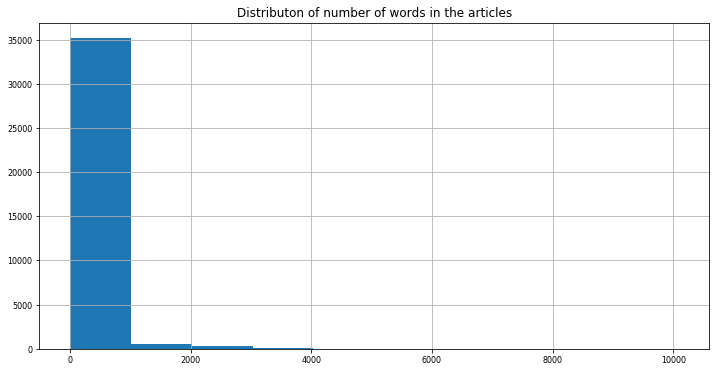

In [38]:
a['length'].hist(figsize=(12, 6), bins=10, xlabelsize=8, ylabelsize=8);
plt.title("Distributon of number of words in the articles")

In [52]:
stopwords_verbs = ['say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']
stopwords_other = ['one', 'mr', 'bbc', 'imag', 'de', 'en', 'caption', 'also', 'copyright', 'something', 
                   'nh', "getti", "pa","don","ap","afp","reuter","pictur", "ve", "didn", "share","septemb",
                   "august","octob","jo","thoma","june","juli","fox","bu",
                  "st","ms"]
my_stopwords = SW + stopwords_verbs + stopwords_other

a['clean_text']= a['clean_text'].map(lambda tokens: [token for token in tokens if token not in my_stopwords])

In [53]:
a

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,txt_counts,title_counts,clean_text
14002,Housing developers get stern warning as two bi...,Get the biggest Daily stories by email Subscri...,"[Angus Young, Image, Hull Daily Mail, Peter Ha...",[http://fox13now.com/@trinitymirrordigital/mar...,None,None,"[East Riding of Yorkshire Council, Cottingham]",GER_2019-04-21_60844_web_page.html,www.hulldailymail.co.uk/news/hull-east-yorkshi...,NaN,uk,1.0,1.0,"[biggest, daili, stori, email, subscrib, subsc..."
9790,The team that feels like a second family,The women of Sutton & Epsom's Ladies RFC are o...,None,[https://ichef.bbci.co.uk/news/320/cpsprodpb/A...,None,en,[],GER_2019-04-09_79634_web_page.html,www.bbc.co.uk/news/in-pictures-47831386,NaN,uk,1.0,1.0,"[women, sutton, epsom, ladi, rfc, game, win, l..."
26217,Piers Morgan admits Mel B's Geri Halliwell sex...,Piers Morgan got a Spice Girls scoop during fi...,[Joanna Crawley For Mailonline],[https://i.dailymail.co.uk/1s/2019/09/13/08/18...,None,en,"[dailymail, tvshowbiz, mel-b]",GER_2019-05-22_72212_web_page.html,www.dailymail.co.uk/tvshowbiz/article-6852087/...,NaN,uk,1.0,1.0,"[pier, morgan, spice, girl, scoop, film, upcom..."
18583,Billy McNeill funeral: Applause across Glasgow...,RAPTUROUS applause was heard across Glasgow on...,None,[http://fox13now.com/resources/static/nile/img...,None,en,[],GER_2019-05-03_51507_web_page.html,eveningtimes.co.uk/news/17617149.billy-mcneill...,NaN,uk,27.0,27.0,"[raptur, applaus, hear, glasgow, friday, funer..."
17757,National Trust axes Belton Horse Trials,Image copyright National Trust Image caption T...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-05-01_80190_web_page.html,www.bbc.co.uk/news/uk-england-lincolnshire-481...,NaN,uk,2.0,2.0,"[nation, trust, nation, trust, forc, threat, i..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21903,Lowestoft sea wall fall cyclist rescued by friend,Image copyright Maritime and Coastguard Agency...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-05-12_11189_web_page.html,bbc.co.uk/news/uk-england-suffolk-48243015,NaN,uk,1.0,2.0,"[maritim, coastguard, agenc, boy, action, frie..."
13900,Sri Lanka bombings: Intelligence blunder ahead...,Key intelligence on a possible terrorist attac...,"[Nicola Smith, Susitha Fernando, Qadijah Irsha...",[http://fox13now.com/content/dam/news/2019/08/...,None,en,"[Sri Lanka, News, World News]",GER_2019-04-21_28710_web_page.html,www.telegraph.co.uk/news/2019/04/21/sri-lanka-...,NaN,uk,2.0,2.0,"[key, intellig, terrorist, attack, pass, sri, ..."
23308,Father of girl photo-bombed by 'ghost-like sam...,'I'm about as skeptical as they come when it c...,[Daniel Piotrowski For Daily Mail Australia],[https://i.dailymail.co.uk/1s/2019/09/06/14/18...,None,en,"[dailymail, news]",GER_2019-05-15_31856_web_page.html,www.dailymail.co.uk/news/article-3050165/Man-T...,NaN,uk,1.0,1.0,"[skeptic, paranorm, guess, good, dwell, stuff,..."
4261,Jussie Smollett: Prosecutors drop all charges ...,Media playback is unsupported on your device M...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-03-26_71575_web_page.html,bbc.co.uk/news/world-us-canada-47711535,NaN,uk,1.0,1.0,"[media, playback, unsupport, devic, media, jus..."


In [57]:
data_lemmatized = list(a['clean_text'])

In [61]:
bigram = gensim.models.Phrases(data_lemmatized, min_count=20, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

texts = [bigram_mod[doc] for doc in data_lemmatized]

In [65]:
# Create Dictionary
id2word = corpora.Dictionary(texts)
# Filter out words that occur less than 30 documents, or more than 50% of the documents.
id2word.filter_extremes(no_below=1, no_above=0.4)

# Create Corpus
texts = texts

In [66]:
corpus = [id2word.doc2bow(text) for text in texts]

In [67]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 38957
Number of documents: 5000


### Crime  - Economic situation - Rising prices/inflation/cost of living - Taxation - Unemployment - Terrorism - Housing - Government debt - Immigration - Health and social security - The education system - Pensions - The environment, climate and energy issues  - Brexit

## Build LDA model

In [143]:
coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
print(coherencemodel.get_coherence())

0.5139682076493863


In [145]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """ 
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics= num_topics, 
                                                   random_state=100,
                                                   iterations = 300,
                                                   update_every=1,
                                                   chunksize=100,
                                                   passes=2,
                                                   alpha=[0.01]*num_topics,
                                                   per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
        print(coherencemodel.get_coherence())

    return model_list, coherence_values

In [146]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=10, limit=25, step=1)

-2.0308264364285313
-1.9980359624678117
-1.7850039981598014
-2.1386424468678165
-2.104697850309672
-2.3329690151767135
-2.2429012876483734
-2.3835341554586913
-2.898607314042571
-2.7946745055638904
-2.5463815204729987
-2.602793828618002
-2.866023815081696
-3.018141493642675
-2.8257812456904916


'''finding the optimal number of topics is to build
many LDA models with different values of number of topics (k) 
and pick the one that gives the highest coherence value.
Best coherence for umass is typically the minimum
'''

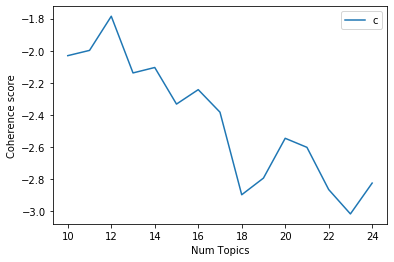

In [147]:
# Show graph
limit=25; start=10; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [148]:
num=18
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics= num, 
                                                   random_state=100,
                                                   iterations = 300,
                                                   update_every=1,
                                                   chunksize=100,
                                                   passes=2,
                                                   alpha=[0.01]*num,
                                                   per_word_topics=True)

In [149]:

for i,topic in lda_model.show_topics(formatted=True, num_topics=18, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.029*"trump" + 0.019*"presid" + 0.018*"campaign" + 0.015*"polit" + 0.011*"meet" + 0.011*"candid" + 0.011*"minist" + 0.011*"countri" + 0.011*"leader" + 0.010*"elect" + 0.010*"govern" + 0.010*"nation" + 0.009*"march" + 0.008*"bori_johnson" + 0.008*"group" + 0.008*"public" + 0.008*"hous" + 0.007*"poll" + 0.007*"johnson" + 0.007*"voter"

1: 0.022*"store" + 0.021*"product" + 0.021*"food" + 0.020*"buy" + 0.019*"sell" + 0.019*"custom" + 0.018*"shop" + 0.017*"price" + 0.015*"busi" + 0.015*"sale" + 0.014*"onlin" + 0.013*"uk" + 0.013*"save" + 0.012*"rat" + 0.011*"offer" + 0.010*"cent" + 0.009*"eat" + 0.009*"car" + 0.009*"free" + 0.009*"retail"

2: 0.040*"pay" + 0.037*"servic" + 0.035*"compani" + 0.032*"council" + 0.019*"firm" + 0.018*"cost" + 0.017*"bank" + 0.016*"plan" + 0.014*"bradford" + 0.014*"busi" + 0.012*"oper" + 0.012*"account" + 0.010*"financi" + 0.010*"fund" + 0.010*"manag" + 0.010*"street" + 0.009*"scheme" + 0.009*"includ" + 0.009*"properti" + 0.009*"charg"

3: 0.044*"babi" + 0.03

In [150]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.214053 -0.071680       1        1  21.073685
14    -0.124212  0.187729       2        1  13.205078
12    -0.180184  0.070979       3        1  11.934216
9     -0.091278  0.098124       4        1   7.016672
0     -0.161684 -0.096723       5        1   6.314148
15    -0.052535  0.053302       6        1   6.281711
11    -0.119190 -0.181729       7        1   5.500934
7     -0.072908  0.018999       8        1   4.815323
6      0.005806 -0.068974       9        1   4.145385
16    -0.017360  0.174211      10        1   4.014801
2     -0.005260 -0.210352      11        1   3.258836
1     -0.002837 -0.154681      12        1   3.237638
3      0.027428  0.229964      13        1   2.981423
8      0.060166 -0.000547      14        1   2.311595
10     0.176238 -0.087081      15        1   1.717801
17     0.171935  0.026047      16        1   1.328060
13     0.288368  0.033922      17        1   0.730009
4      0.311558 -0.021509      18        1   0.132687, topic_info=         Term         Freq        Total Category  logprob  loglift
2488   brexit  5432.000000  5432.000000  Default  30.0000  30.0000
941     polic  4612.000000  4612.000000  Default  29.0000  29.0000
568      deal  5046.000000  5046.000000  Default  28.0000  28.0000
172      vote  3621.000000  3621.000000  Default  27.0000  27.0000
1525   credit  2615.000000  2615.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
652      park     1.886941  1534.437500  Topic18  -6.8404  -0.0760
646     funer     0.418958   209.442413  Topic18  -8.3454   0.4105
7155   financ     0.026998     1.188224  Topic18 -11.0874   2.8405
692     march     0.027443  1834.022339  Topic18 -11.0710  -4.4850
3214  program     0.027036   307.321533  Topic18 -11.0860  -2.7135

[1125 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3167      1  0.996826  abandon
3706      1  0.997014    abort
183       2  0.356001    accid
183      11  0.009622    accid
183      16  0.631821    accid
...     ...       ...      ...
1313      8  0.339440   writer
1313     13  0.033944   writer
1313     17  0.624569   writer
2748      8  0.914605   yellow
2748     12  0.079713   yellow

[3052 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 15, 13, 10, 1, 16, 12, 8, 7, 17, 3, 2, 4, 9, 11, 18, 14, 5])

In [152]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # = dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

TypeError: '<' not supported between instances of 'int' and 'tuple'

In [176]:
max(lda_model.get_document_topics(corpus[0]))
l=[]
for i in range(5000):
    l.append(max(lda_model.get_document_topics(corpus[i]), key=lambda x:x[1]))

In [177]:
l

[(14, 0.33079612),
 (12, 0.43459228),
 (12, 0.6779562),
 (4, 0.44140276),
 (6, 0.6194879),
 (17, 0.5213792),
 (14, 0.6641033),
 (12, 0.4744271),
 (14, 0.7695981),
 (16, 0.5879562),
 (12, 0.30805516),
 (5, 0.45561793),
 (3, 0.38982677),
 (1, 0.76280415),
 (8, 0.47677627),
 (14, 0.5627963),
 (12, 0.40327087),
 (0, 0.30894527),
 (16, 0.31094462),
 (16, 0.73701507),
 (2, 0.7595038),
 (10, 0.48616773),
 (12, 0.8384034),
 (14, 0.7861291),
 (16, 0.35117283),
 (14, 0.5159781),
 (3, 0.36658219),
 (0, 0.34661674),
 (5, 0.71351594),
 (1, 0.41807082),
 (12, 0.6346389),
 (2, 0.5730142),
 (3, 0.39404243),
 (5, 0.6060834),
 (3, 0.7238764),
 (0, 0.5873217),
 (8, 0.4925371),
 (8, 0.4914931),
 (10, 0.57127964),
 (7, 0.5224729),
 (5, 0.49582702),
 (7, 0.7265937),
 (6, 0.62273026),
 (6, 0.6896448),
 (16, 0.7559824),
 (9, 0.41664287),
 (11, 0.6853498),
 (15, 0.394962),
 (12, 0.3792551),
 (0, 0.5784405),
 (10, 0.49037498),
 (16, 0.58537483),
 (12, 0.44375786),
 (5, 0.42640197),
 (0, 0.7085024),
 (17, 0.4551

usage of LDA is when you have no labels, and you want to identify which documents are semantically similar to each other, without necessarily determining what the correct class label for the documents is.

In [178]:
a= a.reset_index()

In [179]:
a["topic_prob"]= l

In [180]:
a

,level_0,index,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,txt_counts,title_counts,clean_text,topic_prob
0,0,14002,Housing developers get stern warning as two bi...,Get the biggest Daily stories by email Subscri...,"[Angus Young, Image, Hull Daily Mail, Peter Ha...",[http://fox13now.com/@trinitymirrordigital/mar...,None,None,"[East Riding of Yorkshire Council, Cottingham]",GER_2019-04-21_60844_web_page.html,www.hulldailymail.co.uk/news/hull-east-yorkshi...,NaN,uk,1.0,1.0,"[biggest, daili, stori, email, subscrib, subsc...","(14, 0.33079612)"
1,1,9790,The team that feels like a second family,The women of Sutton & Epsom's Ladies RFC are o...,None,[https://ichef.bbci.co.uk/news/320/cpsprodpb/A...,None,en,[],GER_2019-04-09_79634_web_page.html,www.bbc.co.uk/news/in-pictures-47831386,NaN,uk,1.0,1.0,"[women, sutton, epsom, ladi, rfc, game, win, l...","(12, 0.43459228)"
2,2,26217,Piers Morgan admits Mel B's Geri Halliwell sex...,Piers Morgan got a Spice Girls scoop during fi...,[Joanna Crawley For Mailonline],[https://i.dailymail.co.uk/1s/2019/09/13/08/18...,None,en,"[dailymail, tvshowbiz, mel-b]",GER_2019-05-22_72212_web_page.html,www.dailymail.co.uk/tvshowbiz/article-6852087/...,NaN,uk,1.0,1.0,"[pier, morgan, spice, girl, scoop, film, upcom...","(12, 0.6779562)"
3,3,18583,Billy McNeill funeral: Applause across Glasgow...,RAPTUROUS applause was heard across Glasgow on...,None,[http://fox13now.com/resources/static/nile/img...,None,en,[],GER_2019-05-03_51507_web_page.html,eveningtimes.co.uk/news/17617149.billy-mcneill...,NaN,uk,27.0,27.0,"[raptur, applaus, hear, glasgow, friday, funer...","(4, 0.44140276)"
4,4,17757,National Trust axes Belton Horse Trials,Image copyright National Trust Image caption T...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-05-01_80190_web_page.html,www.bbc.co.uk/news/uk-england-lincolnshire-481...,NaN,uk,2.0,2.0,"[nation, trust, nation, trust, forc, threat, i...","(6, 0.6194879)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,21903,Lowestoft sea wall fall cyclist rescued by friend,Image copyright Maritime and Coastguard Agency...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-05-12_11189_web_page.html,bbc.co.uk/news/uk-england-suffolk-48243015,NaN,uk,1.0,2.0,"[maritim, coastguard, agenc, boy, action, frie...","(14, 0.28808013)"
4996,4996,13900,Sri Lanka bombings: Intelligence blunder ahead...,Key intelligence on a possible terrorist attac...,"[Nicola Smith, Susitha Fernando, Qadijah Irsha...",[http://fox13now.com/content/dam/news/2019/08/...,None,en,"[Sri Lanka, News, World News]",GER_2019-04-21_28710_web_page.html,www.telegraph.co.uk/news/2019/04/21/sri-lanka-...,NaN,uk,2.0,2.0,"[key, intellig, terrorist, attack, pass, sri, ...","(5, 0.2642039)"
4997,4997,23308,Father of girl photo-bombed by 'ghost-like sam...,'I'm about as skeptical as they come when it c...,[Daniel Piotrowski For Daily Mail Australia],[https://i.dailymail.co.uk/1s/2019/09/06/14/18...,None,en,"[dailymail, news]",GER_2019-05-15_31856_web_page.html,www.dailymail.co.uk/news/article-3050165/Man-T...,NaN,uk,1.0,1.0,"[skeptic, paranorm, guess, good, dwell, stuff,...","(14, 0.3306956)"
4998,4998,4261,Jussie Smollett: Prosecutors drop all charges ...,Media playback is unsupported on your device M...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-03-26_71575_web_page.html,bbc.co.uk/news/world-us-canada-47711535,NaN,uk,1.0,1.0,"[media, playback, unsupport, devic, media, jus...","(15, 0.23465143)"


In [181]:
tup=(9, 0.3433398)
tup[1]

0.3433398

In [187]:
# Number of Documents for Each Topic
topi = a['topic_prob'].apply(lambda x: x[0])
topic_perce= a['topic_prob'].apply(lambda x: x[1])
topic_counts=topi.value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)


# Concatenate Column wise
df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Num_Documents,Perc_Documents
5,1477,0.2954
14,939,0.1878
12,484,0.0968
15,412,0.0824
9,388,0.0776
11,358,0.0716
0,220,0.0440
6,151,0.0302
16,113,0.0226
3,110,0.0220


In [185]:
df_dominant_topics['dominant_topic'] = df_dominant_topics.index

In [192]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

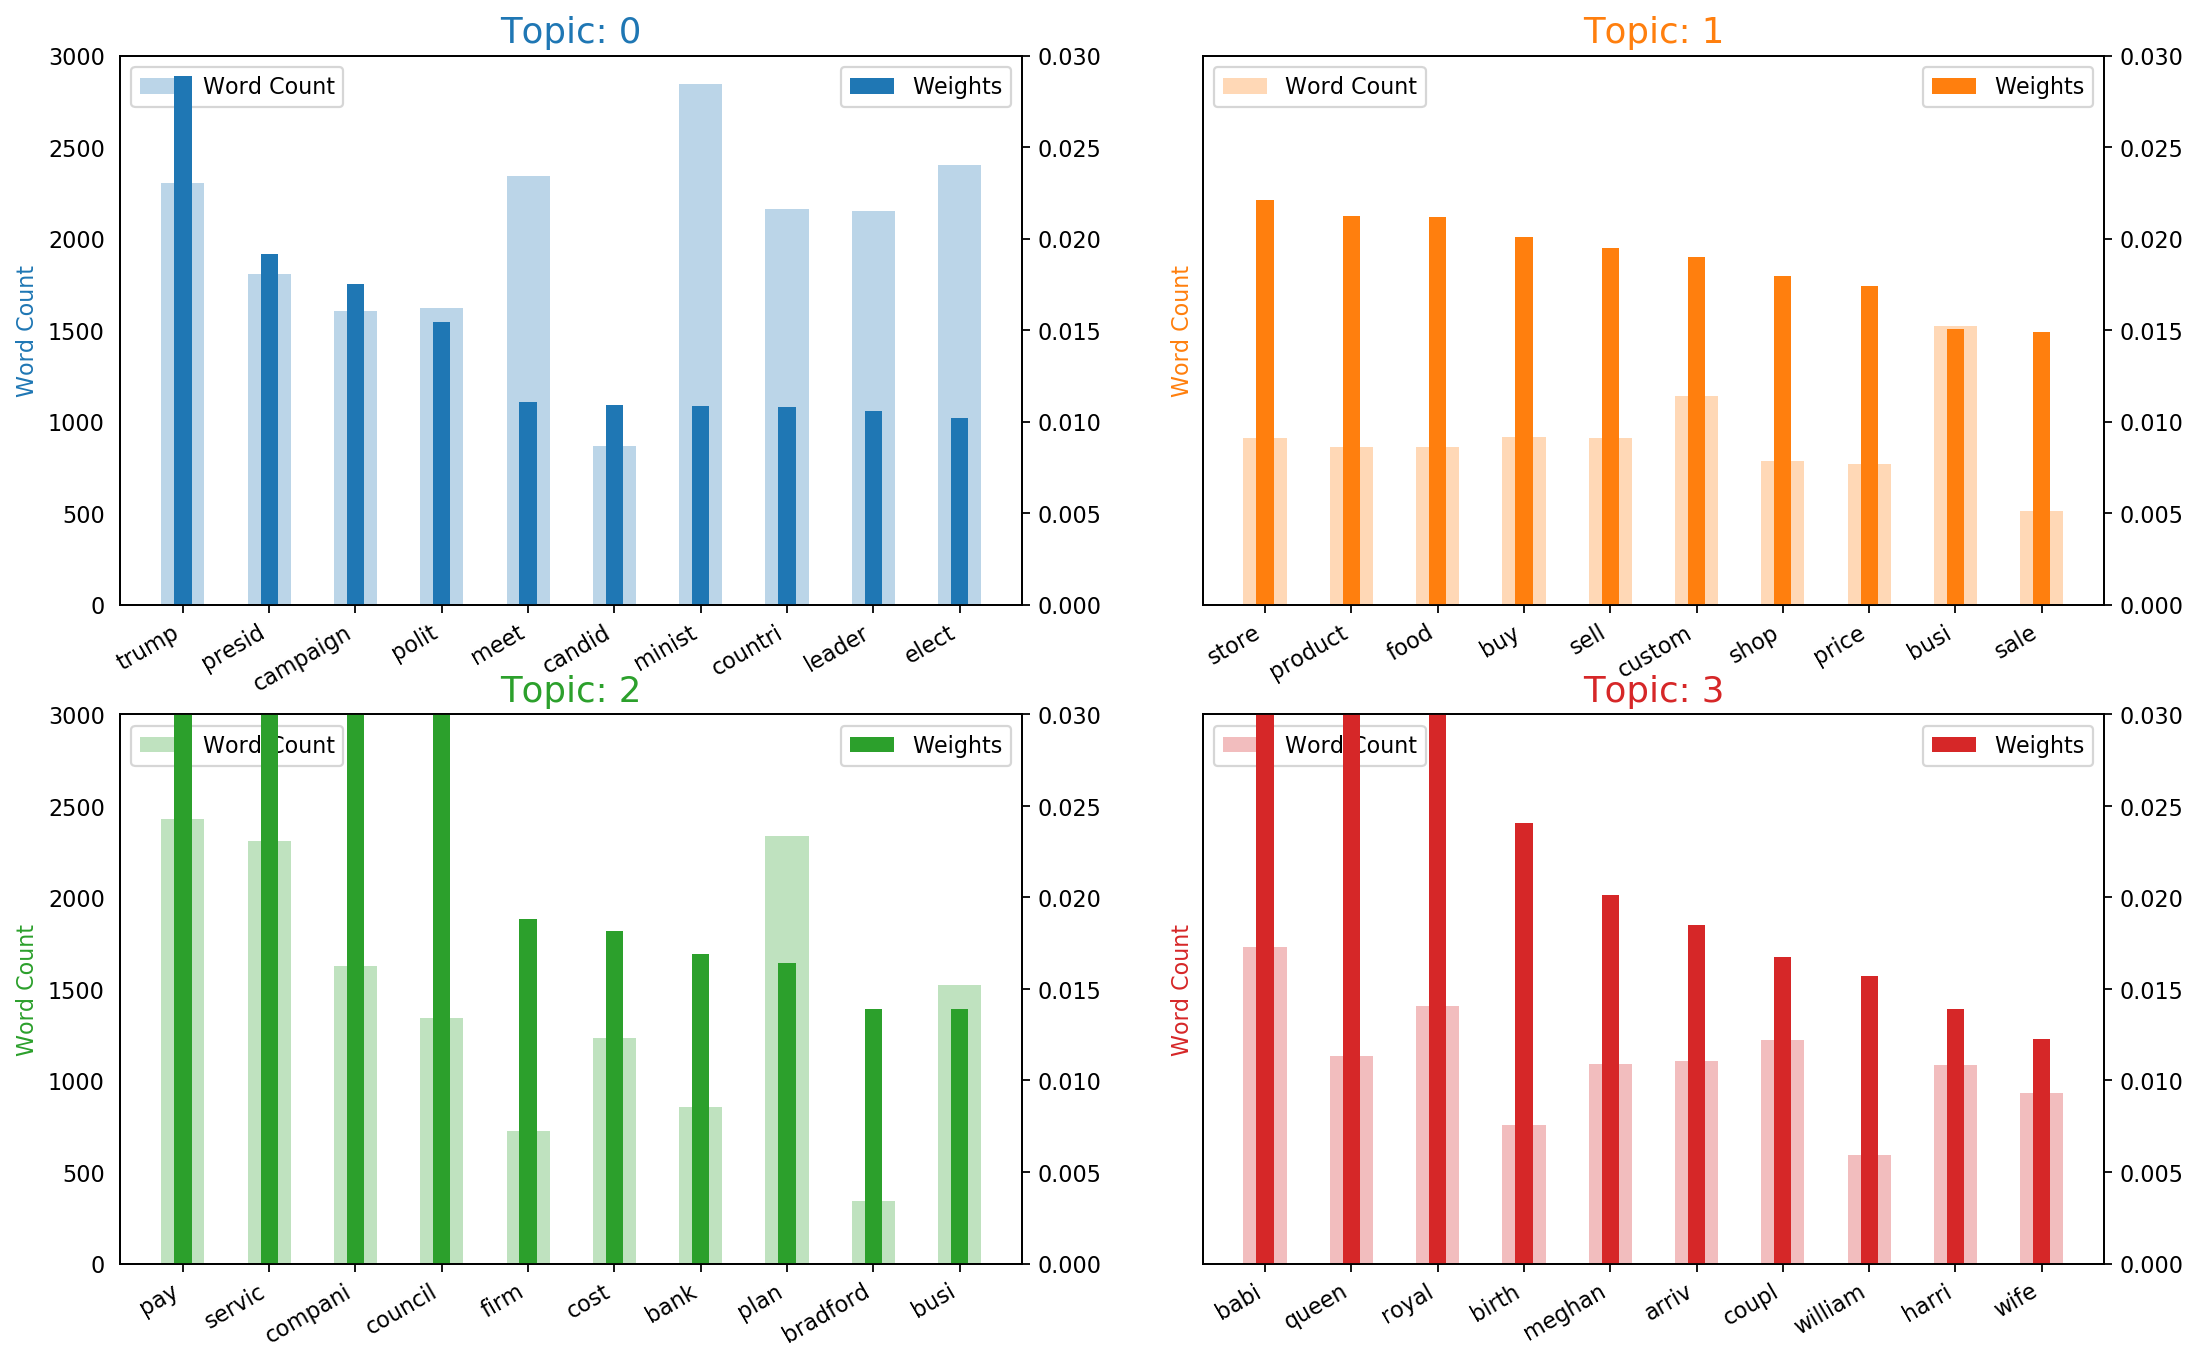

In [198]:
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')



In [196]:
fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()